In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [3]:
import sys
import numpy as np
import pandas as pd
import torch
import pyvista as pv

sys.path.append('../..')
import project
import project.preprocessing
from project.core.utils import pprint

torch.cuda.is_available()

True

In [110]:
config = project.core.fileio.load_config('../../config.yaml')
config

Loading ../../config.yaml


{'dataset': {'name': 'ShapeNet',
  'root': 'data/ShapeNetSem',
  'examples': {'subjects': 'one_subject.csv', 'variant': 'TEST'},
  'metadata': {'parse_metadata': True,
   'unit_policy': 'prefer_metadata',
   'default_unit': 0.01},
  'selectors': {'binary_mask': 'pad37', 'input_image': 'solid'}},
 'preprocessing': {'binary_mask': {'foreground_filter': {'max_components': 1,
    'keep_largest': True},
   'background_filter': {'min_voxels': 30},
   'center_mask': True,
   'pad_amount': 0.37},
  'surface_mesh': {'run_pymeshfix': True},
  'region_mask': {'label_method': 'nearby_faces',
   'region_filter': {'min_voxels': 1000, 'keep_largest': False}},
  'volume_mesh': {'use_affine_spacing': False,
   'meshing_parameters': {'max_facet_distance': 0.75,
    'max_cell_circumradius': 5.0,
    'lloyd': True,
    'odt': True}},
  'material_mask': {'material_catalog': '2025-11-20_materials.csv',
   'material_sampling': {'sample_rate': 0.0001}},
  'material_mesh': {'material_catalog': '2025-11-20_mate

In [5]:
%autoreload
# wss.101354f9d8dede686f7b08d9de913afe - speaker
# wss.1e5abf0465d97d826118a17db9de8c0  - bottle
# wss.fabf4f7a56f75781c9c120e7b18610ad - donut
# wss.38c6a54843046bef5bbc469684caa508 - disconnected
# wss.ce4945cde785aecb478fa0ab37c461c6 - piano
# wss.e91c2df09de0d4b1ed4d676215f46734 - bed (problem: cell labeled as background)
# wss.e91c2df09de0d4b1ed4d676215f46734 - failed preprocessing due to mesh problem?

subj = 'wss.e91c2df09de0d4b1ed4d676215f46734'

data_config = config['dataset'].copy()
data_config['root'] = '../../data/ShapeNetSem'
data_config['examples']['subjects'] = [subj]

ex = project.api.get_examples(data_config)[0]
pprint(ex, max_depth=1)

Gathering examples
Example()
├── dataset:  'ShapeNet'
├── subject:  'wss.e91c2df09de0d4b1ed4d676215f46734'
├── variant:  'TEST'
├── paths:    dict(len=13)
└── metadata: dict(len=4)


# Visualize object mesh

In [6]:
# visualization config
size = 1200
lw = 2.0

Loading ../../data/ShapeNetSem/models-OBJ/models/e91c2df09de0d4b1ed4d676215f46734.obj


2025-11-20 14:57:12.902 (  13.451s) [    155530FB2200]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=


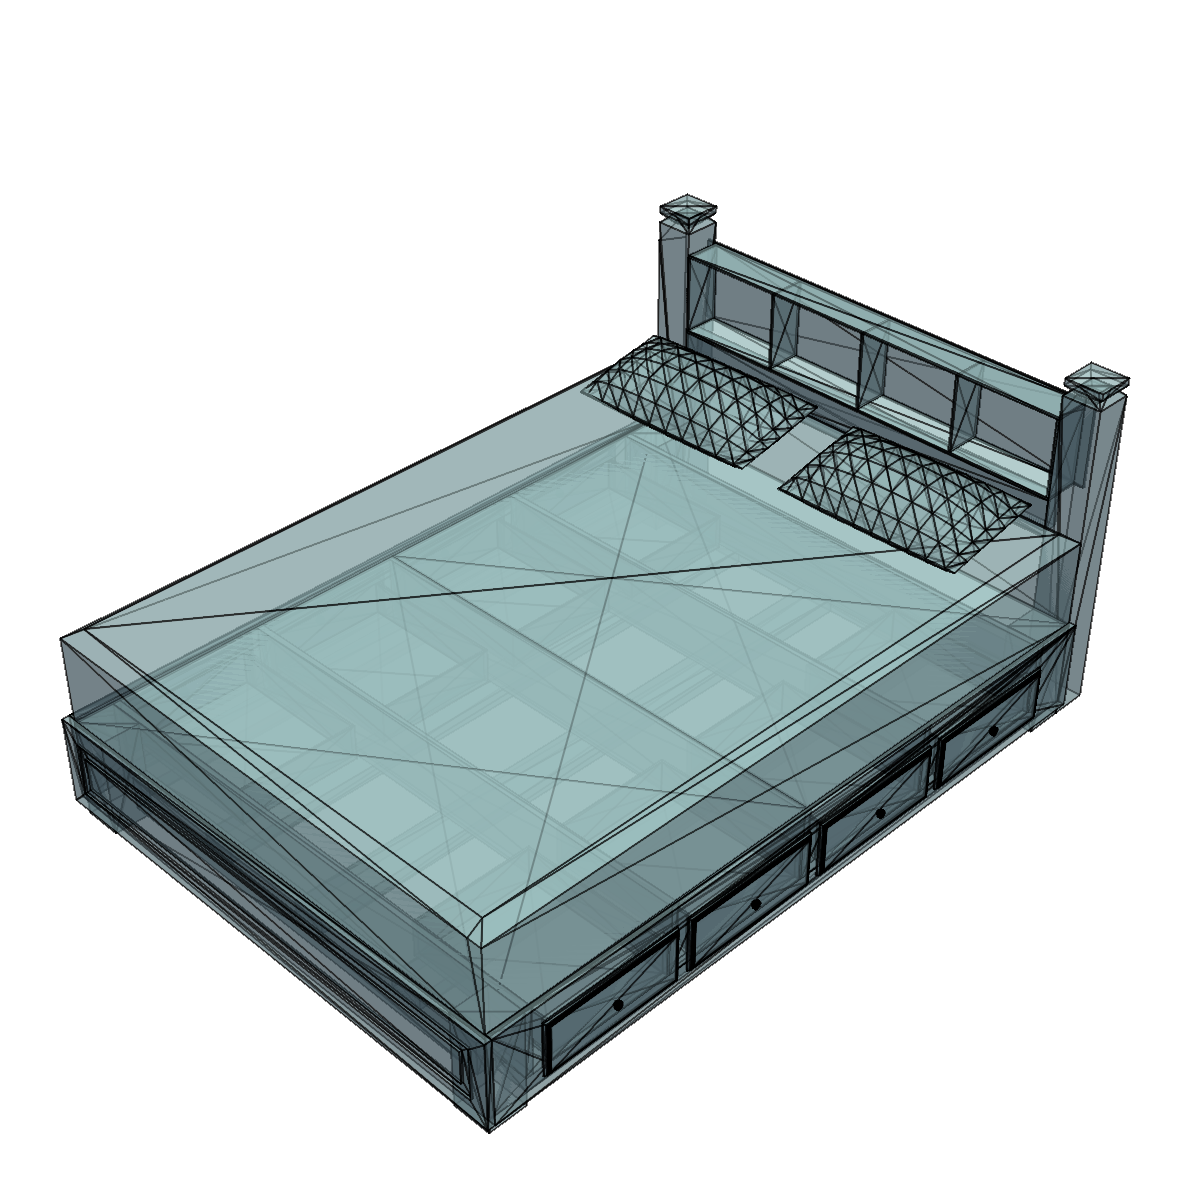

In [7]:
%autoreload
import project.visual.pyvista as pv

src_mesh = project.core.fileio.load_meshio(ex.paths['source_mesh'])

p = pv.pv.Plotter(window_size=[size,size])
pv.plot_mesh(src_mesh, color='lightblue', show_edges=True, opacity=0.5, line_width=lw, plotter=p)
pv.plot_mesh(src_mesh, style='wireframe', color='black', opacity=0.5, line_width=lw, plotter=p)
cam = p.camera
p.show(jupyter_backend='static')

Loading ../../data/ShapeNetSem/models-OBJ/models/e91c2df09de0d4b1ed4d676215f46734.obj


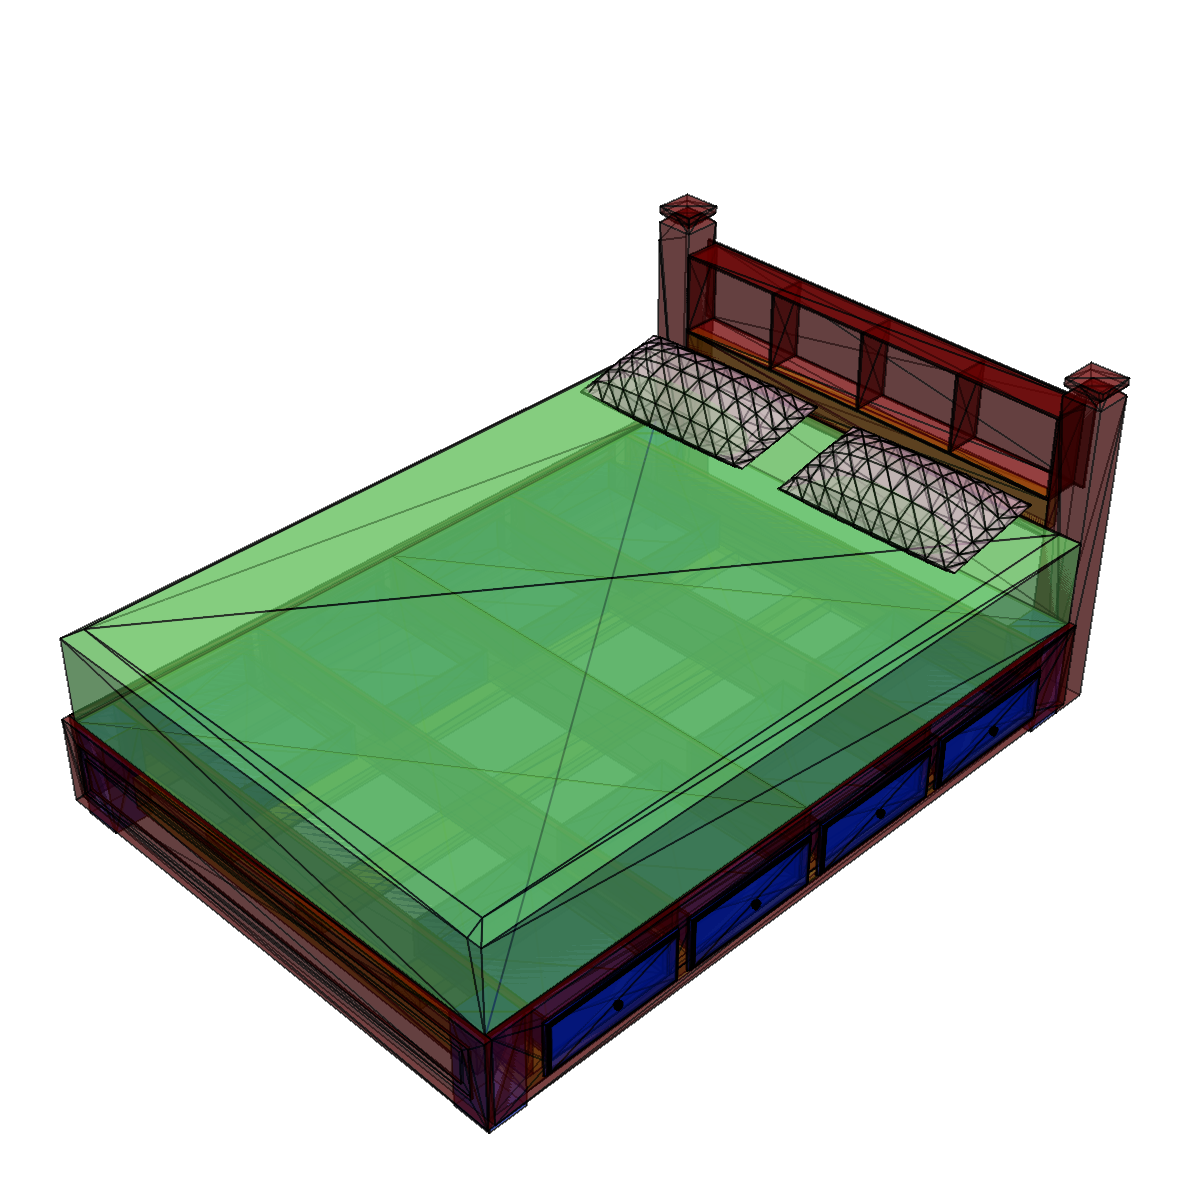

In [9]:
import project.preprocessing.surface_meshing

scene = project.core.fileio.load_trimesh(ex.paths['source_mesh'])
label_mesh, mesh_labels = project.preprocessing.surface_meshing.extract_face_labels(scene)
label_mesh = pv.pv.wrap(label_mesh)
label_mesh.cell_data['label'] = mesh_labels

p = pv.pv.Plotter(window_size=[size,size])
pv.plot_mesh(label_mesh, scalar='label', cmap='jet', show_edges=True, opacity=0.5, line_width=lw, plotter=p, show_scalar_bar=False)
pv.plot_mesh(src_mesh, style='wireframe', color='black', opacity=0.5, line_width=lw, plotter=p)
p.camera = cam
p.show(jupyter_backend='static')

# Preprocess binary mask

In [10]:
%autoreload
project.preprocessing.stages.preprocess_binary_mask(
    mask_path=ex.paths['source_mask'],
    mesh_path=ex.paths['source_mesh'],
    output_path=ex.paths['binary_mask'],
    config=config['preprocessing']['binary_mask']
)

Loading ../../data/ShapeNetSem/models-OBJ/models/e91c2df09de0d4b1ed4d676215f46734.obj
Loading ../../data/ShapeNetSem/models-binvox-solid/e91c2df09de0d4b1ed4d676215f46734.binvox
Binvox shape:     [128 128 128]
Binvox translate: [77.75  1.75 -1.75]
Binvox scale:     0.0127389
Points bbox min:    [-77.75  -1.75   1.75]
Points bbox extent: [78.5    56.5    34.9937]
(-1, -1)
[[  0.61327901   0.           0.         -77.44336049]
 [  0.           0.61327901   0.          -1.44336049]
 [  0.           0.           0.61327901   2.05663951]
 [  0.           0.           0.           1.        ]]
Filtering foreground (removing blobs)
Input 1-connected components: 10
  Voxel counts:   [309245      9      4      2      2      2      1      1      1      1] 309268
Output 1-connected components: 1
  Voxels dropped: 23 (0.0074%)
Filtering background (filling holes)
Input 1-connected components: 15
  Voxel counts:   [1787670      70      40      32      29      21      13      11       7
       4     

Loading ../../data/ShapeNetSem/TEST/e91c2df09de0d4b1ed4d676215f46734/masks/pad37.nii.gz


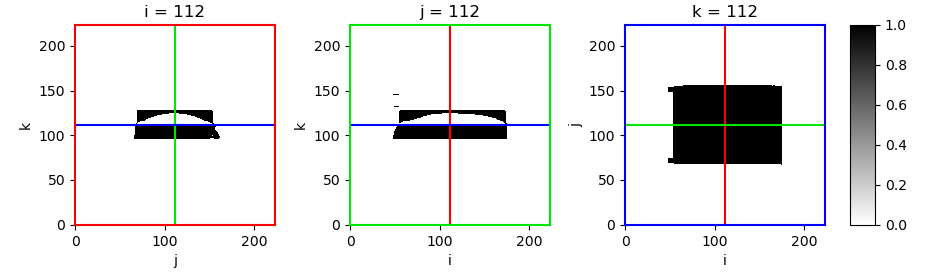

In [11]:
bin_nifti = project.core.fileio.load_nibabel(ex.paths['binary_mask'])
bin_mask, bin_affine = bin_nifti.get_fdata(), bin_nifti.affine

_ = project.visual.matplotlib.show_image_slices(bin_mask, cmap='binary', clim=(0,1))

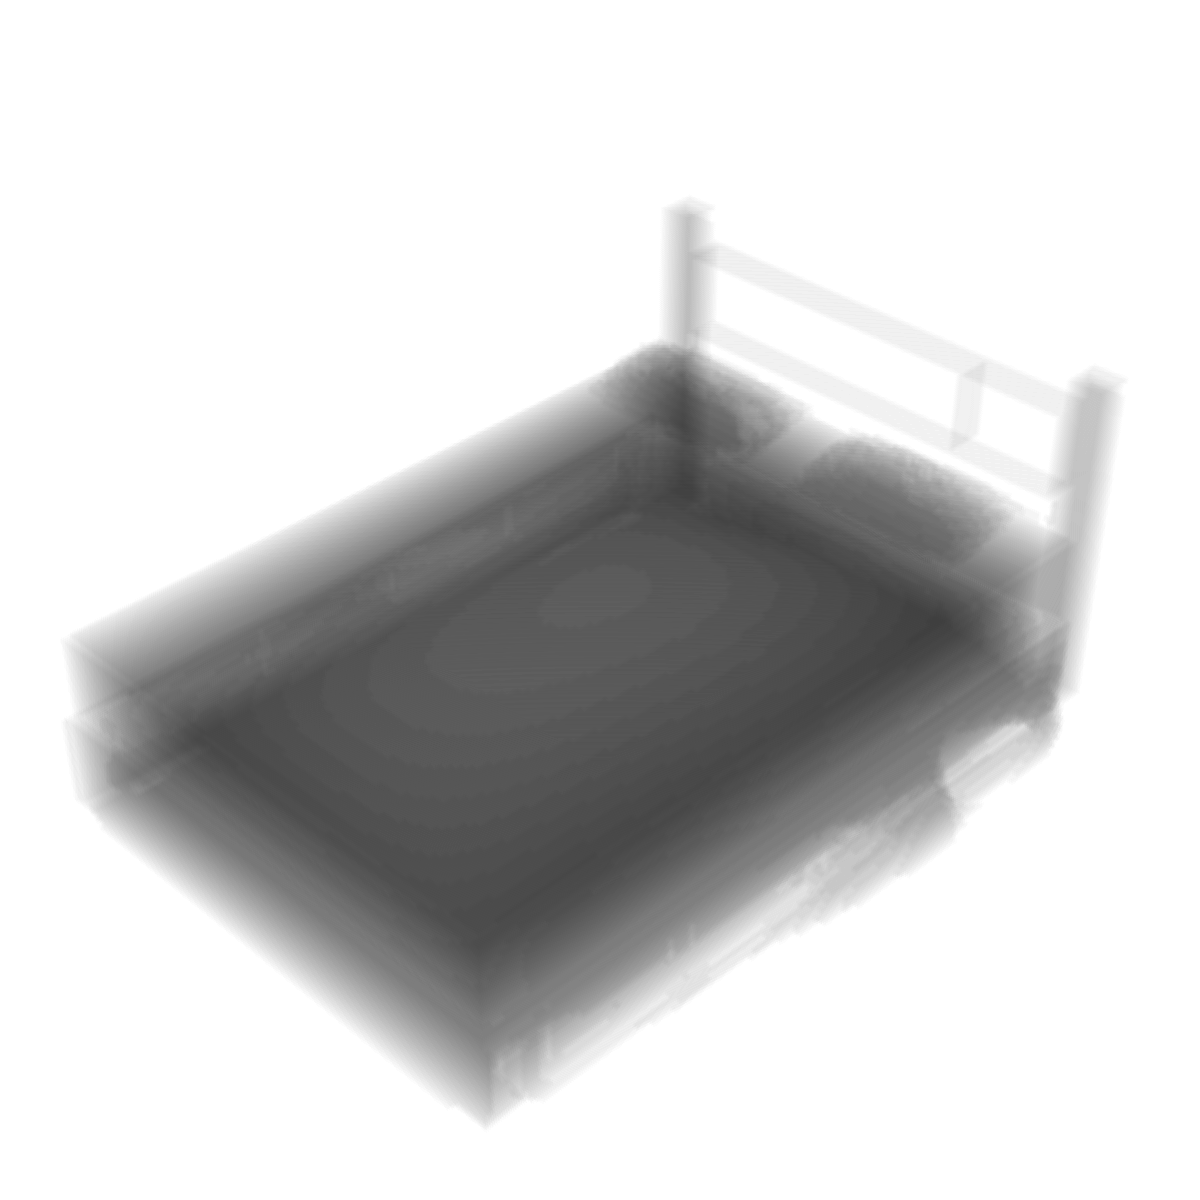

In [12]:
p = project.visual.pyvista.pv.Plotter(window_size=(size,size))
p = project.visual.pyvista.plot_volume(bin_mask, bin_affine, cmap=['black'], clim=(0, 1), opacity=[0,0.05], plotter=p, show_scalar_bar=False)
#p = project.visual.pyvista.plot_mesh(src_mesh, color='lightblue', opacity=0.1, plotter=p, show_scalar_bar=False)
p.camera = cam
p.show(jupyter_backend='static')

# Preprocess surface mesh

In [13]:
project.preprocessing.stages.preprocess_surface_mesh(
    input_path=ex.paths['source_mesh'],
    output_path=ex.paths['surface_mesh'],
    config=config['preprocessing']['surface_mesh']
)

Loading ../../data/ShapeNetSem/models-OBJ/models/e91c2df09de0d4b1ed4d676215f46734.obj
Repairing surface mesh
Initial mesh state:
dict(len=7)
├── 'vertices':     25836
├── 'faces':        8612
├── 'edges':        dict(len=3)
|   ├── 'boundary':    25836
|   ├── 'interior':    0
|   └── 'nonmanifold': 0
├── 'euler_number': 8612
├── 'watertight':   False
├── 'components':   8612
└── 'angles':       dict(len=3)
    ├── 'p05': 0.23672632469023844
    ├── 'p50': 60.6120680670191
    └── 'p95': 133.859938007577

After trimesh repair:
dict(len=7)
├── 'vertices':     2239
├── 'faces':        4222
├── 'edges':        dict(len=3)
|   ├── 'boundary':    252
|   ├── 'interior':    6175
|   └── 'nonmanifold': 16
├── 'euler_number': 18
├── 'watertight':   False
├── 'components':   65
└── 'angles':       dict(len=3)
    ├── 'p05': 0.24878607082030074
    ├── 'p50': 65.03775591087708
    └── 'p95': 134.09061955080085
INFO- Loaded 2239 vertices and 4222 faces.
Removed 62 small components
Fixing degenera

WARNING- Some cuts were necessary to cope with non manifold configuration.


Loading ../../data/ShapeNetSem/TEST/e91c2df09de0d4b1ed4d676215f46734/meshes/trimesh.xdmf


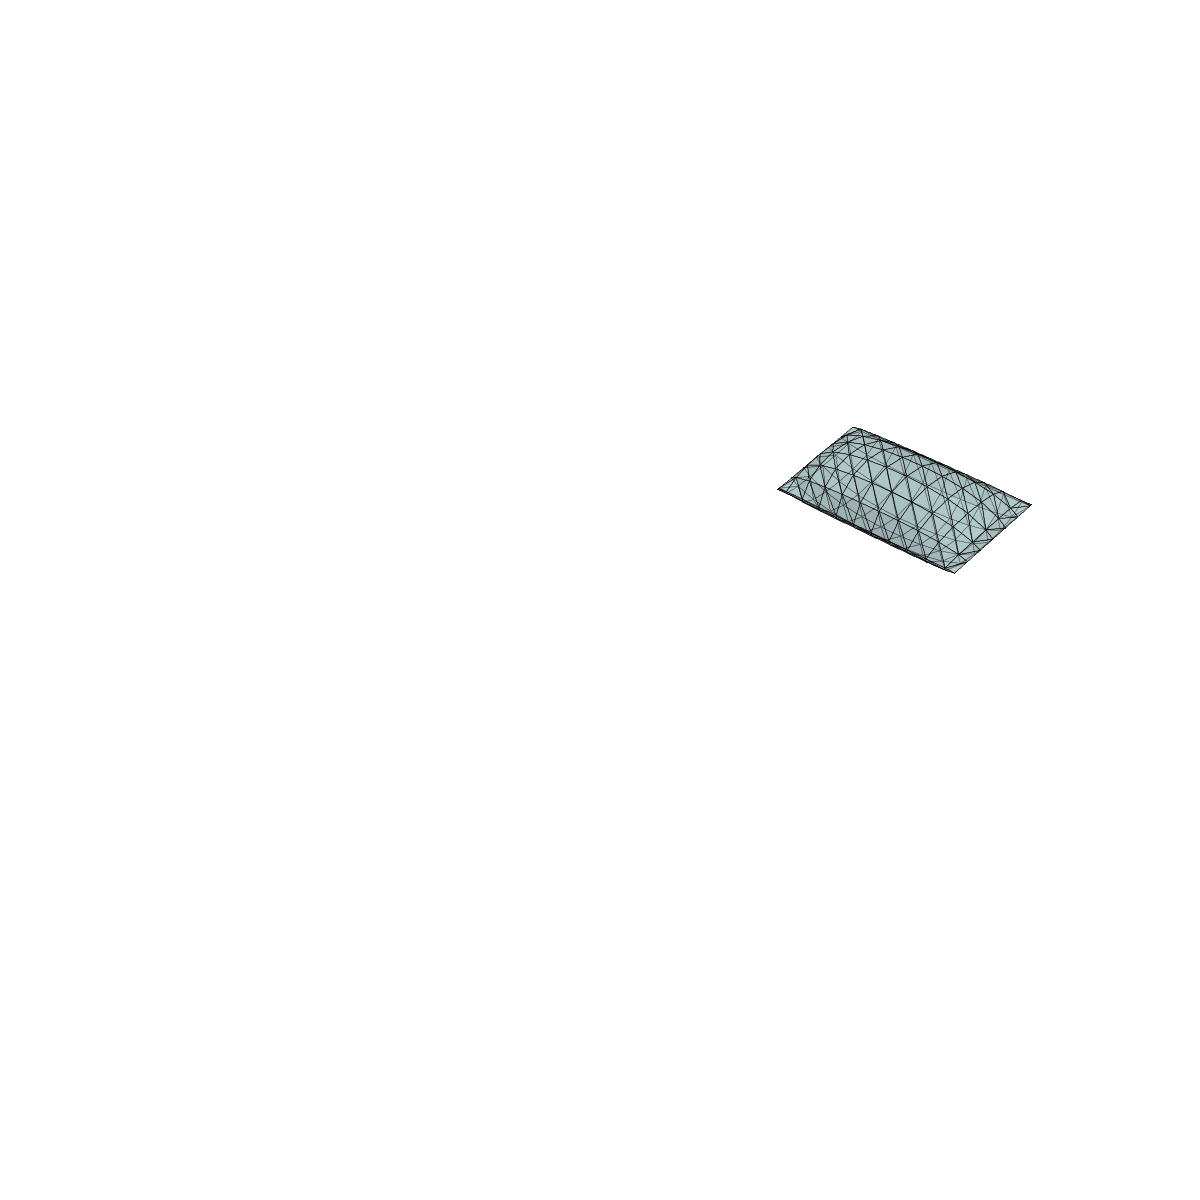

In [14]:
tri_mesh = project.core.fileio.load_meshio(ex.paths['surface_mesh'])

size = 1200
p = pv.pv.Plotter(window_size=[size,size])
pv.plot_mesh(tri_mesh, color='lightblue', show_edges=True, opacity=0.5, plotter=p)
pv.plot_mesh(tri_mesh, style='wireframe', color='black', opacity=0.5, plotter=p)
p.camera = cam
p.show(jupyter_backend='static')

# Create region mask from mesh parts

In [15]:
project.preprocessing.stages.create_mesh_region_mask(
    mask_path=ex.paths['binary_mask'],
    mesh_path=ex.paths['source_mesh'],
    output_path=ex.paths['region_mask'],
    config=config['preprocessing']['region_mask']
)

Loading ../../data/ShapeNetSem/TEST/e91c2df09de0d4b1ed4d676215f46734/masks/pad37.nii.gz
Loading ../../data/ShapeNetSem/models-OBJ/models/e91c2df09de0d4b1ed4d676215f46734.obj
Extracting labels from mesh
Assigning labels to voxels
100%|██████████| 31/31 [00:41<00:00,  1.35s/it]
Cleaning up region mask
Filtering region 1
Input 1-connected components: 2
  Voxel counts:   [178736      1] 178737
Output 1-connected components: 1
  Voxels dropped: 1 (0.0006%)
Filtering region 2
Input 1-connected components: 10
  Voxel counts:   [40798 39877     2     1     1     1     1     1     1     1] 80684
Output 1-connected components: 2
  Voxels dropped: 9 (0.0112%)
Filtering region 3
Input 1-connected components: 10
  Voxel counts:   [26449    29    13    11     8     6     6     1     1     1] 26525
Output 1-connected components: 1
  Voxels dropped: 76 (0.2865%)
Filtering region 4
Input 1-connected components: 13
  Voxel counts:   [1240 1232  873  774   65   60   57   57   30   25    3    3    1] 4420

Loading ../../data/ShapeNetSem/TEST/e91c2df09de0d4b1ed4d676215f46734/masks/pad37_regions.nii.gz


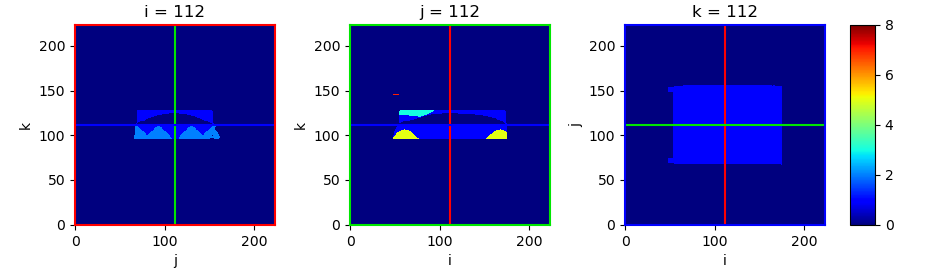

In [16]:
%autoreload
import project.visual.matplotlib
region_nifti = project.core.fileio.load_nibabel(ex.paths['region_mask'])
region_mask = region_nifti.get_fdata().astype(int)

fig = project.visual.matplotlib.show_image_slices(region_mask, cmap='jet', clim=(0, 8))

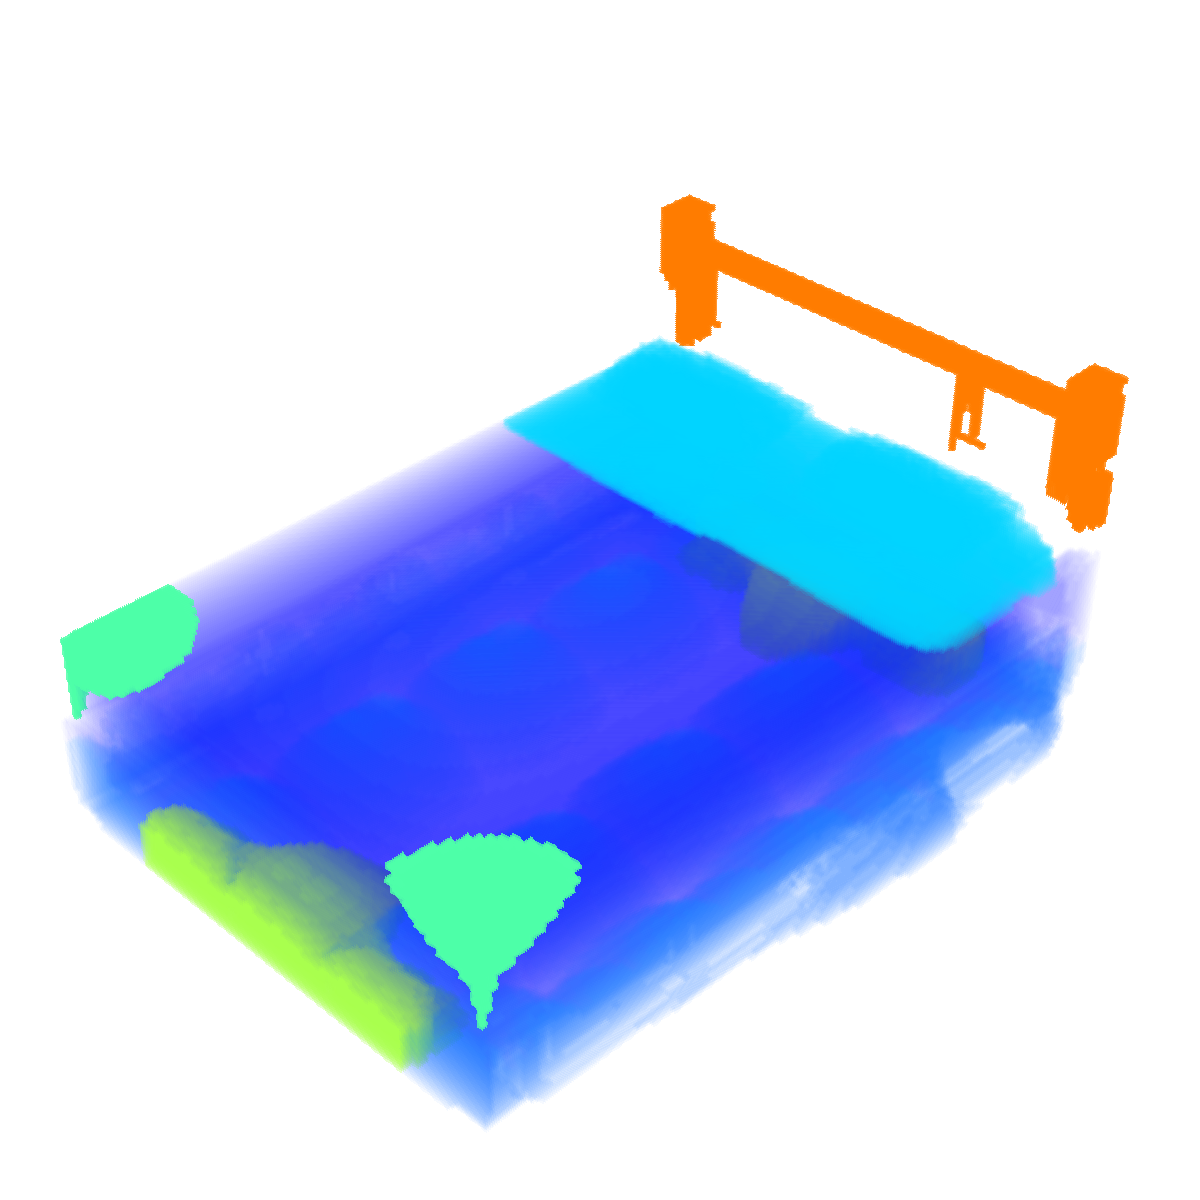

In [17]:
def _opacity(a, n, alpha=20000, relative=False):
    clim = (0, n - 1)
    freqs, edges = np.histogram(a, range=clim, bins=n, density=relative)
    sel = (freqs > 0) & (edges[:-1] > 0)
    opacity = np.zeros_like(freqs, dtype=float)
    opacity[sel] = np.minimum(alpha / freqs[sel], 1.0)
    return clim, opacity

clim, opacity = _opacity(region_mask, n=10, alpha=10000)
p = project.visual.pyvista.pv.Plotter(window_size=(size,size))
p = project.visual.pyvista.plot_volume(region_mask, bin_affine, cmap='jet', clim=clim, opacity=opacity, plotter=p, show_scalar_bar=False)
#p = project.visual.pyvista.plot_volume(region_mask, bin_affine, cmap='jet', clim=(0, 8), opacity=opacity, plotter=p, show_scalar_bar=False)
#p = project.visual.pyvista.plot_mesh(src_mesh, style='wireframe', color='black', plotter=p, show_scalar_bar=False)
p.camera = cam
p.show(jupyter_backend='static')

# Generate volume mesh from region mask

In [50]:
%autoreload
project.preprocessing.stages.create_volume_mesh_from_mask(
    mask_path=ex.paths['region_mask'],
    output_path=ex.paths['volume_mesh'],
    config=config['preprocessing']['volume_mesh']
)

Loading ../../data/ShapeNetSem/TEST/e91c2df09de0d4b1ed4d676215f46734/masks/pad37_regions.nii.gz
Generating volume mesh from mask
Constructing cell label map
medit:ref = 1 | total = 12651 | region counts = [  306 12211    95    12    16    11]
medit:ref = 2 | total = 6127 | region counts = [  38   71 5996    0    0   22]
medit:ref = 3 | total = 2619 | region counts = [  51   95    0 2473]
medit:ref = 4 | total = 281 | region counts = [  0   2   0   0 279]
medit:ref = 5 | total = 1490 | region counts = [   0   24   37    0    0 1429]
medit:ref = 6 | total = 1 | region counts = [1]
[-1  1  2  3  4  5  0]
Removed 1 background cell(s)
Removed 11 unreferenced point(s)
Mesh has 2 connected component(s)
<meshio mesh object>
  Number of points: 5862
  Number of cells:
    tetra: 23168
  Cell data: medit:ref, region
Saving ../../data/ShapeNetSem/TEST/e91c2df09de0d4b1ed4d676215f46734/meshes/pad37_regions_tetmesh.xdmf


Loading ../../data/ShapeNetSem/TEST/e91c2df09de0d4b1ed4d676215f46734/meshes/pad37_regions_tetmesh.xdmf


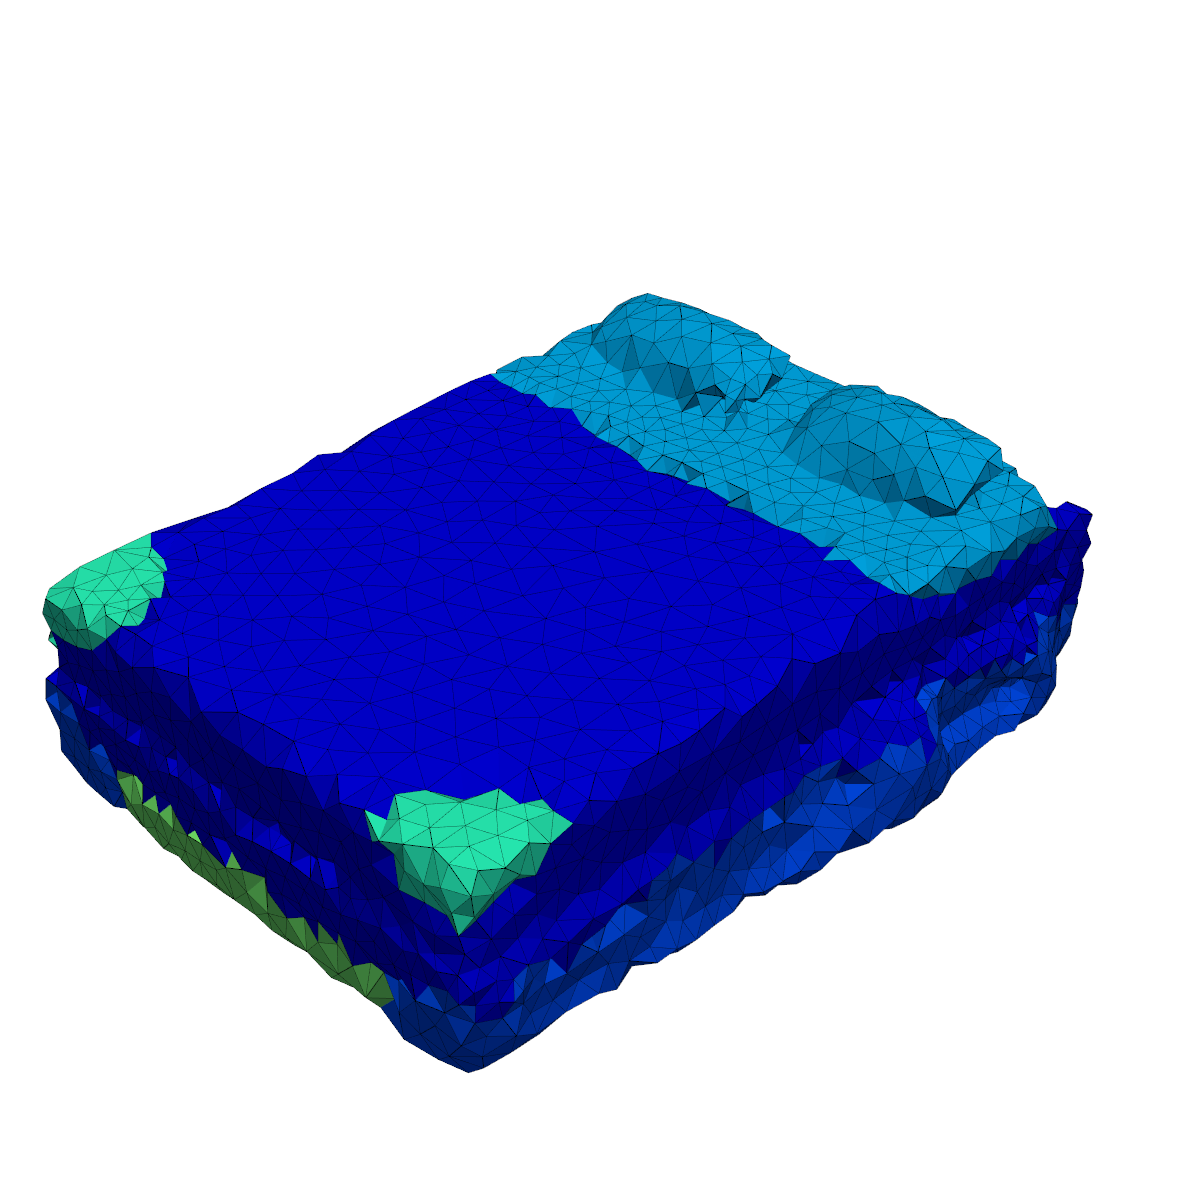

In [48]:
vol_mesh = project.core.fileio.load_meshio(ex.paths['volume_mesh'])
p = project.visual.pyvista.pv.Plotter(window_size=(size,size))
p = project.visual.pyvista.plot_mesh(vol_mesh, scalar='region', cmap='jet', clim=(0, 10), opacity=1.0, plotter=p, show_scalar_bar=False)
p = project.visual.pyvista.plot_mesh(vol_mesh, style='wireframe', color='black', plotter=p, show_scalar_bar=False)
#p.camera = cam
p.show(jupyter_backend='static')

# Assign materials and properties

In [75]:
import project.preprocessing.materials
req_cols = ['material_name', 'density_val', 'elastic_val', 'material_freq']
mat_df = pd.DataFrame([
    ('VeryHard', 500., 9e3, 0.1),
    ('Hard',     500., 5e3, 0.2),
    ('Medium',   500., 3e3, 0.4),
    ('Soft',     500., 2e3, 0.2),
    ('VerySoft', 500., 1e3, 0.1),
], columns=req_cols)
mat_df

material_name  density_val  elastic_val  material_freq
0      VeryHard        500.0       9000.0            0.1
1          Hard        500.0       5000.0            0.2
2        Medium        500.0       3000.0            0.4
3          Soft        500.0       2000.0            0.2
4      VerySoft        500.0       1000.0            0.1

In [72]:
mat_df.to_csv('2025-11-20_materials.csv', index=False)

In [77]:
project.preprocessing.stages.create_material_mask(
    mask_path=ex.paths['region_mask'],
    output_path=ex.paths['material_mask'],
    density_path=ex.paths['density_field'],
    elastic_path=ex.paths['elastic_field'],
    config=config['preprocessing']['material_mask']
)

Loading ../../data/ShapeNetSem/TEST/e91c2df09de0d4b1ed4d676215f46734/masks/pad37_regions.nii.gz
Loading material catalog
  material_name  density_val  elastic_val  material_freq
0    Background          0.0          0.0            0.0
1      VeryHard        500.0       9000.0            0.1
2          Hard        500.0       5000.0            0.2
3        Medium        500.0       3000.0            0.4
4          Soft        500.0       2000.0            0.2
5      VerySoft        500.0       1000.0            0.1
Sampling materials per region
Region labels: [1 2 3 4 5 7]
Region sizes:  [179103  81320  26815   2472  14963   2456]
Region votes:  [17.9103  8.132   2.6815  1.      1.4963  1.    ]
Building region adjacency graph
Material prior: [0.1 0.2 0.4 0.2 0.1]
Region 1 was assigned material 3 in prior
Region 2 was assigned material 1 in prior
Region 3 was assigned material 4 in prior
Region 5 was assigned material 4 in prior
Region 4 was assigned material 4 in prior
Region 7 was assi

Loading ../../data/ShapeNetSem/TEST/e91c2df09de0d4b1ed4d676215f46734/masks/pad37_regions_material.nii.gz


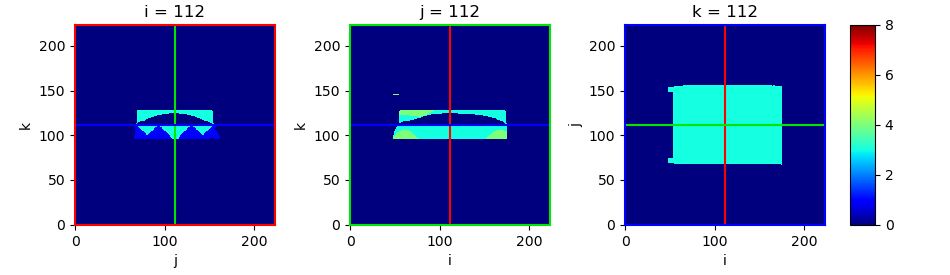

In [78]:
mask = project.core.fileio.load_nibabel(ex.paths['material_mask']).get_fdata()
_ = project.visual.matplotlib.show_image_slices(mask, cmap='jet', clim=(0, 8))

In [79]:
project.preprocessing.stages.create_material_fields(
    regions_path=ex.paths['region_mask'],
    materials_path=ex.paths['material_mask'],
    mesh_path=ex.paths['volume_mesh'],
    output_path=ex.paths['material_mesh'],
    config=config['preprocessing']['material_mesh']
)

Loading ../../data/ShapeNetSem/TEST/e91c2df09de0d4b1ed4d676215f46734/masks/pad37_regions.nii.gz
Loading ../../data/ShapeNetSem/TEST/e91c2df09de0d4b1ed4d676215f46734/masks/pad37_regions_material.nii.gz
Loading ../../data/ShapeNetSem/TEST/e91c2df09de0d4b1ed4d676215f46734/meshes/pad37_regions_tetmesh.xdmf
Loading material catalog
  material_name  density_val  elastic_val  material_freq
0    Background          0.0          0.0            0.0
1      VeryHard        500.0       9000.0            0.1
2          Hard        500.0       5000.0            0.2
3        Medium        500.0       3000.0            0.4
4          Soft        500.0       2000.0            0.2
5      VerySoft        500.0       1000.0            0.1
Saving ../../data/ShapeNetSem/TEST/e91c2df09de0d4b1ed4d676215f46734/meshes/pad37_regions_material_tetmesh_mat.xdmf


# Forward FEM simulation

In [72]:
%autoreload
project.preprocessing.api.simulate_displacement_field(
    mesh_path=ex.paths['mesh_fields'],
    output_path=ex.paths['mesh_fields'],
    unit_m=float(ex.metadata['unit']),
    device='cuda'
)

mesh = project.core.fileio.load_meshio(ex.paths['mesh_fields'])
mesh

p = project.visual.pyvista.pv.Plotter(window_size=(size,size))
p = project.visual.pyvista.plot_mesh(mesh, scalar='E', cmap='jet', clim=(0, 1e4), opacity=0.8, plotter=p, show_scalar_bar=False)
#p = project.visual.pyvista.plot_mesh(fem_mesh, style='wireframe', color='black', plotter=p, show_scalar_bar=False)
#p.camera = cam
p.show(jupyter_backend='static')

p = project.visual.pyvista.pv.Plotter(window_size=(size,size))
p = project.visual.pyvista.plot_mesh(mesh, scalar='rho', cmap='binary', opacity=0.8, plotter=p, show_scalar_bar=False)
#p = project.visual.pyvista.plot_mesh(fem_mesh, style='wireframe', color='black', plotter=p, show_scalar_bar=False)
#p.camera = cam
p.show(jupyter_backend='static')

p = project.visual.pyvista.pv.Plotter(window_size=(size,size))
p = project.visual.pyvista.plot_mesh(mesh, style='wireframe', color='black', plotter=p, opacity=0.1, line_width=lw, show_scalar_bar=False)
p.add_mesh(project.visual.pyvista.pv.wrap(mesh).glyph(scale='u', orient='u', factor=8), cmap='jet', show_scalar_bar=False)
p.camera = cam
p.show(jupyter_backend='static')

Loading ../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/meshes/fields.xdmf
Simulating displacement using material fields
Simulating displacement using PDE solver
Module warp.optim.linear 5c44d62 load on device 'cuda:0' took 3.62 ms  (cached)
u (3246, 3) float32 -1.6190499
bc (3246, 3) float32 0.0
res (3246, 3) float32 0.0
Saving ../../data/ShapeNetSem/2025-11-02/1e5abf0465d97d826118a17db9de8c0/meshes/fields.xdmf


# Texture annotations

In [60]:
import os
tex = pd.read_csv('2025-10-21_annotations.csv')
tex.path = tex.path.map(os.path.abspath)

# manual corrections/additional annotations
tex.loc[[1, 76, 42], 'annotation'] = 'marble'
tex.loc[88, 'annotation'] = 'brick'
tex.loc[80, 'annotation'] = 'stone'
tex.loc[ 8, 'annotation'] = 'fiberboard'
tex.loc[[84, 90], 'annotation'] = 'grass'
tex.loc[97, 'annotation'] = 'stone'
tex.loc[ 3, 'annotation'] = 'cardboard'
tex.loc[[27, 72, 54, 89, 74, 73], 'annotation'] = 'paper'
tex.loc[[74, 100], 'annotation'] = 'fabric'
tex.loc[[34], 'annotation'] = 'stone'
tex.loc[[98, 103], 'annotation'] = 'gravel'
tex.loc[[56], 'annotation'] = 'paint'
tex.loc[[101], 'annotation'] = 'paper'

tex.loc[:, 'is_texture'] = True
tex.loc[[32, 82, 13, 41, 113, 33, 87, 7, 28, 20, 56, 3, 77], 'is_texture'] = False

tex.loc[:, 'is_duplicate'] = False
tex.loc[[10, 12, 29, 40, 57, 60, 61, 71, 95, 80, 51, 22, 105, 59, 94, 68, 69, 109, 110, 4, 23, 24, 36, 43, 47, 62, 79, 18, 26, 76, 90, 106, 38], 'is_duplicate'] = True

tex.loc[:, 'poor_quality'] = False
tex.loc[[5, 45, 17, 48, 67, 92, 83, 81, 53, 2, 16, 39, 88, 49, 21], 'poor_quality'] = True

tex.loc[:, 'bad_shape'] = False
tex.loc[[73, 89, 75, 97, 85, 19, 107, 100, 111], 'bad_shape'] = True

tex.loc[:, 'inverted'] = False
tex.loc[[55], 'inverted'] = True
tex

idx                                               path annotation  \
0    18231  /ocean/projects/asc170022p/mtragoza/lung-proje...     carpet   
1    17033  /ocean/projects/asc170022p/mtragoza/lung-proje...     marble   
2    18752  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
3    17435  /ocean/projects/asc170022p/mtragoza/lung-proje...  cardboard   
4     3048  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
..     ...                                                ...        ...   
109     42  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
110  12807  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
111   5066  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
112   5531  /ocean/projects/asc170022p/mtragoza/lung-proje...    leather   
113   1626  /ocean/projects/asc170022p/mtragoza/lung-proje...      metal   

     is_texture  is_duplicate  poor_quality  bad_shape  inverted  
0          True         False         False      False     False  
1          True         False         False      False     False  
2          True         False          True      False     False  
3         False         False         False      False     False  
4          True          True         False      False     False  
..          ...           ...           ...        ...       ...  
109        True          True         False      False     False  
110        True          True         False      False     False  
111        True         False         False       True     False  
112        True         False         False      False     False  
113       False         False         False      False     False  

[114 rows x 8 columns]

In [16]:
texture_type_to_material = {
    'paper':   'DenseSoft',
    'leather': 'DenseMedium',
    'stone':   'DenseHard',
    'fabric':  'PorousSoft',
    'wood':    'PorousMedium',
    'marble':  'PorousHard'
}
is_valid = tex.is_texture & ~(tex.is_duplicate | tex.poor_quality | tex.bad_shape)
tex.loc[is_valid, 'material'] = tex.annotation.map(texture_type_to_material)
tex.groupby('material').count()

idx  path  annotation  is_texture  is_duplicate  poor_quality  \
material                                                                      
DenseHard       3     3           3           3             3             3   
DenseMedium     4     4           4           4             4             4   
DenseSoft       4     4           4           4             4             4   
PorousHard      3     3           3           3             3             3   
PorousMedium    4     4           4           4             4             4   
PorousSoft      4     4           4           4             4             4   

              bad_shape  inverted  
material                           
DenseHard             3         3  
DenseMedium           4         4  
DenseSoft             4         4  
PorousHard            3         3  
PorousMedium          4         4  
PorousSoft            4         4

In [17]:
#tex.to_csv('texture_annotations_2025-10-25.csv', index=False)

In [18]:
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet'

6 4


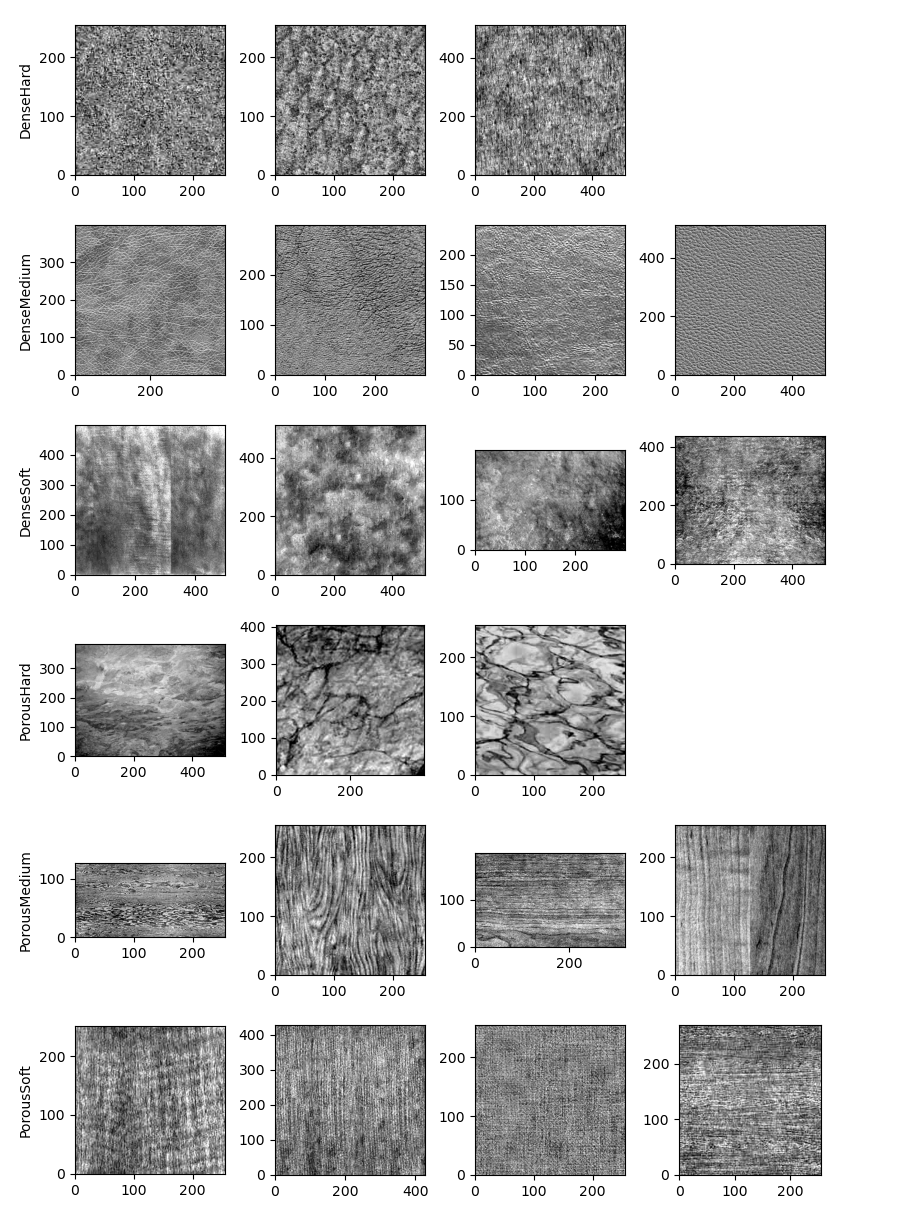

In [86]:
tex_cache = project.preprocessing.texturing.build_texture_cache(
    path='2025-10-25_annotations.csv',
    iqr_mult=4.0
)
_ = project.preprocessing.texturing.show_textures(tex_cache.dropna().set_index('material'))

In [153]:
import os
tex_cache['tid'] = tex_cache['path'].map(lambda p: os.path.splitext(os.path.basename(p))[0])
tex_cache['solid_path'] = tex_cache['tid'].map(lambda p: os.path.join(stn_root, f'{p}.nii'))
tex_cache['has_solid'] = tex_cache['solid_path'].map(os.path.isfile)
tex_cache

idx                                               path annotation  \
0    18231  /ocean/projects/asc170022p/mtragoza/lung-proje...     carpet   
1    17033  /ocean/projects/asc170022p/mtragoza/lung-proje...     marble   
2    18752  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
3    17435  /ocean/projects/asc170022p/mtragoza/lung-proje...  cardboard   
4     3048  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
..     ...                                                ...        ...   
109     42  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
110  12807  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
111   5066  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
112   5531  /ocean/projects/asc170022p/mtragoza/lung-proje...    leather   
113   1626  /ocean/projects/asc170022p/mtragoza/lung-proje...      metal   

     is_texture  is_duplicate  poor_quality  bad_shape  inverted     material  \
0          True         False         False      False     False          NaN   
1          True         False         False      False     False   PorousHard   
2          True         False          True      False     False          NaN   
3         False         False         False      False     False          NaN   
4          True          True         False      False     False          NaN   
..          ...           ...           ...        ...       ...          ...   
109        True          True         False      False     False          NaN   
110        True          True         False      False     False          NaN   
111        True         False         False       True     False          NaN   
112        True         False         False      False     False  DenseMedium   
113       False         False         False      False     False          NaN   

                                                 image               tid  \
0    [[0.33454344, 0.6776649, 0.33454344, -0.214450...  e6808abd1cabdb24   
1    [[-0.40393445, -0.33110657, -0.26356593, -0.28...  7f0e6f6c35b92937   
2    [[-0.44608647, -0.44608647, -0.35414773, -0.07...  6db39e57639bf9d9   
3    [[1.0, 0.8230684, 0.68741035, 0.74088115, 0.77...  5313c2eeedd0125e   
4    [[0.046150718, -0.21117082, -0.28466192, -0.02...  796afcb7cc115983   
..                                                 ...               ...   
109  [[-0.22436179, -0.28468704, -0.4053375, -0.405...  d15eba3dff90a924   
110  [[-0.47208318, -0.28346837, -0.28346837, -0.28...  ffd0685cc9fdb37d   
111  [[0.3253993, 0.3253993, 0.31027263, 0.3403518,...  7243d927dcd5591e   
112  [[-0.3016089, -0.34987748, -0.56708616, -0.205...  17fababfd85461d1   
113  [[-0.3723731, -0.25, 0.035537235, 0.32107446, ...  1a304374facc41b3   

                                            solid_path  has_solid  
0    /ocean/projects/asc170022p/mtragoza/SolidTextu...      False  
1    /ocean/projects/asc170022p/mtragoza/SolidTextu...      False  
2    /ocean/projects/asc170022p/mtragoza/SolidTextu...      False  
3    /ocean/projects/asc170022p/mtragoza/SolidTextu...      False  
4    /ocean/projects/asc170022p/mtragoza/SolidTextu...      False  
..                                                 ...        ...  
109  /ocean/projects/asc170022p/mtragoza/SolidTextu...      False  
110  /ocean/projects/asc170022p/mtragoza/SolidTextu...      False  
111  /ocean/projects/asc170022p/mtragoza/SolidTextu...      False  
112  /ocean/projects/asc170022p/mtragoza/SolidTextu...       True  
113  /ocean/projects/asc170022p/mtragoza/SolidTextu...      False  

[114 rows x 13 columns]

In [154]:
tex_cache[tex_cache.has_solid]

idx                                               path annotation  \
6     4902  /ocean/projects/asc170022p/mtragoza/lung-proje...    leather   
9    19893  /ocean/projects/asc170022p/mtragoza/lung-proje...      stone   
14   17986  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
15   20609  /ocean/projects/asc170022p/mtragoza/lung-proje...     fabric   
27   21243  /ocean/projects/asc170022p/mtragoza/lung-proje...      paper   
30    5286  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
31   10918  /ocean/projects/asc170022p/mtragoza/lung-proje...     fabric   
34    7835  /ocean/projects/asc170022p/mtragoza/lung-proje...      stone   
42    3332  /ocean/projects/asc170022p/mtragoza/lung-proje...     marble   
44   13040  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
46   16689  /ocean/projects/asc170022p/mtragoza/lung-proje...      stone   
50    6344  /ocean/projects/asc170022p/mtragoza/lung-proje...     fabric   
54    2146  /ocean/projects/asc170022p/mtragoza/lung-proje...      paper   
55    7902  /ocean/projects/asc170022p/mtragoza/lung-proje...     marble   
64   14537  /ocean/projects/asc170022p/mtragoza/lung-proje...    leather   
72    9413  /ocean/projects/asc170022p/mtragoza/lung-proje...      paper   
74   13590  /ocean/projects/asc170022p/mtragoza/lung-proje...     fabric   
96    5504  /ocean/projects/asc170022p/mtragoza/lung-proje...    leather   
101  10655  /ocean/projects/asc170022p/mtragoza/lung-proje...      paper   
108     35  /ocean/projects/asc170022p/mtragoza/lung-proje...       wood   
112   5531  /ocean/projects/asc170022p/mtragoza/lung-proje...    leather   

     is_texture  is_duplicate  poor_quality  bad_shape  inverted  \
6          True         False         False      False     False   
9          True         False         False      False     False   
14         True         False         False      False     False   
15         True         False         False      False     False   
27         True         False         False      False     False   
30         True         False         False      False     False   
31         True         False         False      False     False   
34         True         False         False      False     False   
42         True         False         False      False     False   
44         True         False         False      False     False   
46         True         False         False      False     False   
50         True         False         False      False     False   
54         True         False         False      False     False   
55         True         False         False      False      True   
64         True         False         False      False     False   
72         True         False         False      False     False   
74         True         False         False      False     False   
96         True         False         False      False     False   
101        True         False         False      False     False   
108        True         False         False      False     False   
112        True         False         False      False     False   

         material                                              image  \
6     DenseMedium  [[0.2775573, 0.31255072, -0.08738207, -0.12237...   
9       DenseHard  [[0.5625, 0.03125, -0.3125, -0.15625, 0.1875, ...   
14   PorousMedium  [[-0.19273575, -0.033357855, 0.08055496, 0.027...   
15     PorousSoft  [[0.57493937, 0.81178844, 0.7525762, 0.2196657...   
27      DenseSoft  [[0.8036085, 0.6369415, 0.5536082, 0.5536082, ...   
30   PorousMedium  [[-0.36722708, -0.41444668, -0.46166632, -0.36...   
31     PorousSoft  [[0.7858724, 0.399532, 0.013191582, -0.1799786...   
34      DenseHard  [[0.012953353, -0.25393695, -0.25222063, -0.15...   
42     PorousHard  [[-1.0, -1.0, -1.0, -1.0, -0.870204, -0.741029...   
44   PorousMedium  [[-0.68449104, -0.4751938, -0.31822088, -0.370...   
46      DenseHard  [[0.7490162, 0.7490162, 0.

In [289]:
sol = tex_cache[tex_cache.has_solid].reset_index()

sol.loc[0, 'solid_valid'] = True
sol.loc[0, 'solid_annotation'] = 'leather'

sol.loc[1, 'solid_valid'] = False
sol.loc[1, 'solid_annotation'] = 'stone, some LFO'

sol.loc[2, 'solid_valid'] = True
sol.loc[2, 'solid_annotation'] = 'wood, anisotropic'

sol.loc[3, 'solid_valid'] = True
sol.loc[3, 'solid_annotation'] = 'fine fabric'

sol.loc[4, 'solid_valid'] = False
sol.loc[4, 'solid_annotation'] = 'paper - holes'

sol.loc[5, 'solid_valid'] = True
sol.loc[5, 'solid_annotation'] = 'wood, very aniso'
sol.loc[5, 'solid_selected'] = True

sol.loc[6, 'solid_valid'] = True
sol.loc[6, 'solid_annotation'] = 'fabric, gridlike'

sol.loc[7, 'solid_valid'] = True
sol.loc[7, 'solid_annotation'] = 'stone'
sol.loc[7, 'solid_selected'] = True

sol.loc[8, 'solid_valid'] = True
sol.loc[8, 'solid_annotation'] = 'marble, good!'
sol.loc[8, 'solid_selected'] = True

sol.loc[9, 'solid_valid'] = True
sol.loc[9, 'solid_annotation'] = 'wood, aniso'

sol.loc[10, 'solid_valid'] = False
sol.loc[10, 'solid_annotation'] = 'stone, stripey holes'

sol.loc[11, 'solid_valid'] = False
sol.loc[11, 'solid_annotation'] = 'fabric, large blobs'

sol.loc[12, 'solid_valid'] = True
sol.loc[12, 'solid_annotation'] = 'paper, pretty good'

sol.loc[13, 'solid_valid'] = True
sol.loc[13, 'solid_annotation'] = 'marble - interesting'

sol.loc[14, 'solid_valid'] = True
sol.loc[14, 'solid_annotation'] = 'leather, some spots'

sol.loc[15, 'solid_valid'] = True
sol.loc[15, 'solid_annotation'] = 'paper, good'
sol.loc[15, 'solid_selected'] = True

sol.loc[16, 'solid_valid'] = True
sol.loc[16, 'solid_annotation'] = 'fabric, good'
sol.loc[16, 'solid_selected'] = True

sol.loc[17, 'solid_valid'] = True
sol.loc[17, 'solid_annotation'] = 'leather, good'

sol.loc[18, 'solid_valid'] = True
sol.loc[18, 'solid_annotation'] = 'paper, decent'

sol.loc[19, 'solid_valid'] = True
sol.loc[19, 'solid_annotation'] = 'wood, ok'

sol.loc[20, 'solid_valid'] = True
sol.loc[20, 'solid_annotation'] = 'leather, very good'
sol.loc[20, 'solid_selected'] = True

sol[sol.solid_selected.notna()]

index    idx                                               path  \
5      30   5286  /ocean/projects/asc170022p/mtragoza/lung-proje...   
7      34   7835  /ocean/projects/asc170022p/mtragoza/lung-proje...   
8      42   3332  /ocean/projects/asc170022p/mtragoza/lung-proje...   
15     72   9413  /ocean/projects/asc170022p/mtragoza/lung-proje...   
16     74  13590  /ocean/projects/asc170022p/mtragoza/lung-proje...   
20    112   5531  /ocean/projects/asc170022p/mtragoza/lung-proje...   

   annotation  is_texture  is_duplicate  poor_quality  bad_shape  inverted  \
5        wood        True         False         False      False     False   
7       stone        True         False         False      False     False   
8      marble        True         False         False      False     False   
15      paper        True         False         False      False     False   
16     fabric        True         False         False      False     False   
20    leather        True         False         False      False     False   

        material                                              image  \
5   PorousMedium  [[-0.36722708, -0.41444668, -0.46166632, -0.36...   
7      DenseHard  [[0.012953353, -0.25393695, -0.25222063, -0.15...   
8     PorousHard  [[-1.0, -1.0, -1.0, -1.0, -0.870204, -0.741029...   
15     DenseSoft  [[-0.23199572, -0.21180023, -0.11082268, -0.07...   
16    PorousSoft  [[-0.34242475, -0.58153695, -0.5018329, -0.103...   
20   DenseMedium  [[-0.3016089, -0.34987748, -0.56708616, -0.205...   

                 tid                                         solid_path  \
5   2001a5b9a15a670c  /ocean/projects/asc170022p/mtragoza/SolidTextu...   
7   a6c66d0eeaca8c03  /ocean/projects/asc170022p/mtragoza/SolidTextu...   
8   b25c0f2ee0edc563  /ocean/projects/asc170022p/mtragoza/SolidTextu...   
15  80703cf49d2a14c5  /ocean/projects/asc170022p/mtragoza/SolidTextu...   
16  e99e6b2fa82e040a  /ocean/projects/asc170022p/mtragoza/SolidTextu...   
20  17fababfd85461d1  /ocean/projects/asc170022p/mtragoza/SolidTextu...   

    has_solid solid_valid    solid_annotation solid_selected  
5        True        True    wood, very aniso           True  
7        True        True               stone           True  
8        True        True       marble, good!           True  
15       True        True         paper, good           True  
16       True        True        fabric, good           True  
20       True        True  leather, very good           True

index                                                             112
idx                                                              5531
path                /ocean/projects/asc170022p/mtragoza/lung-proje...
annotation                                                    leather
is_texture                                                       True
is_duplicate                                                    False
poor_quality                                                    False
bad_shape                                                       False
inverted                                                        False
material                                                  DenseMedium
image               [[-0.3016089, -0.34987748, -0.56708616, -0.205...
tid                                                  17fababfd85461d1
solid_path          /ocean/projects/asc170022p/mtragoza/SolidTextu...
has_solid                                                        True
solid_valid         

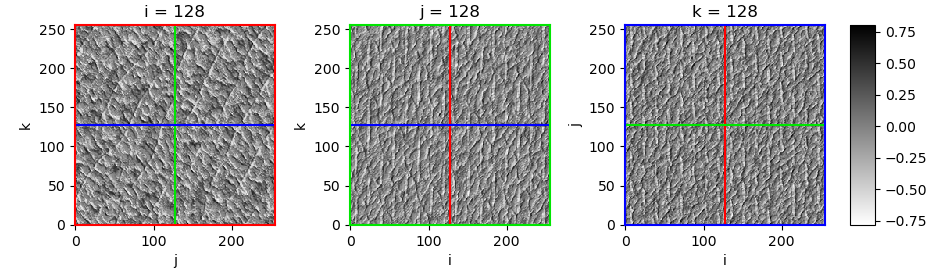

In [292]:
%%time
import nibabel as nib

def preprocess3d(a, iqr_mult=6.0):
    import skimage
    x = skimage.util.img_as_float(a)
    x = skimage.color.rgb2gray(x)
    x = project.preprocessing.texturing._normalize_iqr(x, iqr_mult=iqr_mult)
    x = np.clip(x, -1., 1.).astype(np.float32)
    return x

row = sol.loc[20]
print(row)

t = preprocess3d(nib.load(row.solid_path).get_fdata()[:256,:256,:256])
_ = project.visual.matplotlib.show_image_slices(t, cmap='binary')

# Image generation

In [111]:
tex_df = pd.read_csv('2025-11-05_annotations.csv')
tex_df['image_path'] = tex_df['path']
tex_df['image_annotation'] = tex_df['annotation']
tex_df['image_valid'] = ~tex_df['material'].isna()
tex_df['solid_valid'] = tex_df['solid_selected']
tex_df['texture_class'] = tex_df['image_annotation']
tex_df = tex_df[['tid', 'texture_class', 'image_path', 'image_annotation', 'image_valid', 'solid_path', 'solid_annotation', 'solid_valid', 'inverted']]
tex_df.to_csv('2025-11-20_annotations.csv', index=False)
tex_df.head()

tid texture_class  \
0  8a1b661a4dd6aa56       leather   
1  7961ca6ba8321e68         stone   
2  7f0c33324e26f5c9          wood   
3  cc619f4203d2f2a7        fabric   
4  b0d1ade26ee8c663         paper   

                                          image_path image_annotation  \
0  /ocean/projects/asc170022p/mtragoza/lung-proje...          leather   
1  /ocean/projects/asc170022p/mtragoza/lung-proje...            stone   
2  /ocean/projects/asc170022p/mtragoza/lung-proje...             wood   
3  /ocean/projects/asc170022p/mtragoza/lung-proje...           fabric   
4  /ocean/projects/asc170022p/mtragoza/lung-proje...            paper   

   image_valid                                         solid_path  \
0         True  /ocean/projects/asc170022p/mtragoza/SolidTextu...   
1         True  /ocean/projects/asc170022p/mtragoza/SolidTextu...   
2         True  /ocean/projects/asc170022p/mtragoza/SolidTextu...   
3         True  /ocean/projects/asc170022p/mtragoza/SolidTextu...   
4         True  /ocean/projects/asc170022p/mtragoza/SolidTextu...   

    solid_annotation solid_valid  inverted  
0            leather         NaN     False  
1    stone, some LFO         NaN     False  
2  wood, anisotropic         NaN     False  
3        fine fabric         NaN     False  
4      paper - holes         NaN     False

In [113]:
%autoreload
project.preprocessing.stages.generate_volumetric_image(
    mask_path=ex.paths['material_mask'],
    output_path=ex.paths['input_image'],
    config=config['preprocessing']['image_generation']
)

Loading ../../data/ShapeNetSem/TEST/e91c2df09de0d4b1ed4d676215f46734/masks/pad37_regions_material.nii.gz
Loading material catalog
Computing intensity model
  material_name  density_val  elastic_val  material_freq texture_class  \
0    Background          0.0          0.0            0.0           0.0   
1      VeryHard        500.0       9000.0            0.1         stone   
2          Hard        500.0       5000.0            0.2        marble   
3        Medium        500.0       3000.0            0.4       leather   
4          Soft        500.0       2000.0            0.2        fabric   
5      VerySoft        500.0       1000.0            0.1         paper   

   density_feat    elastic_feat  intensity_bias  intensity_range  
0      0.000001  1000000.000000        0.000001         1.000000  
1      0.500000        0.111111        0.500000         0.055556  
2      0.500000        0.200000        0.500000         0.100000  
3      0.500000        0.333333        0.500000         0

Loading ../../data/ShapeNetSem/TEST/e91c2df09de0d4b1ed4d676215f46734/images/pad37_regions_material_solid.nii.gz
Loading ../../data/ShapeNetSem/TEST/e91c2df09de0d4b1ed4d676215f46734/fields/pad37_regions_material_density.nii.gz
Loading ../../data/ShapeNetSem/TEST/e91c2df09de0d4b1ed4d676215f46734/fields/pad37_regions_material_elastic.nii.gz
(-0.12652984261512756, 1.176598310470581)


NameError: name 'material' is not defined

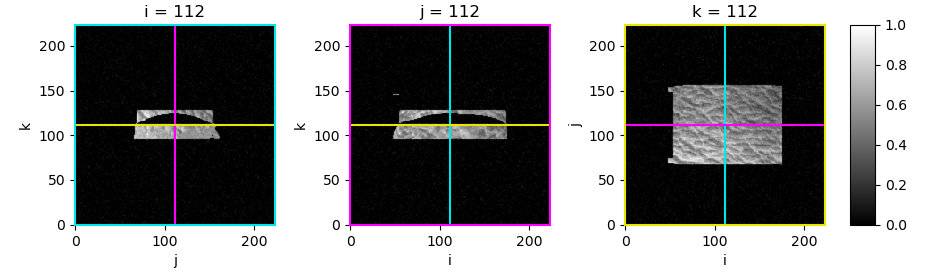

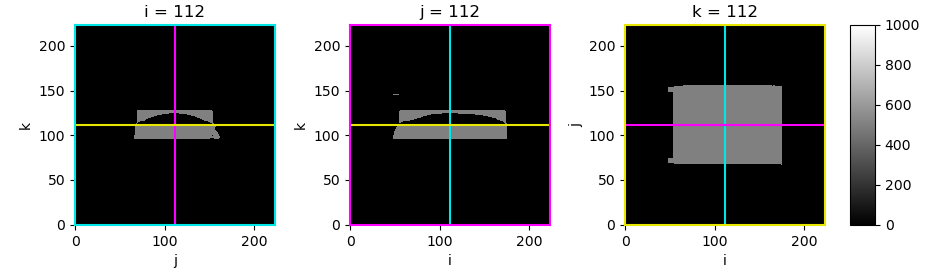

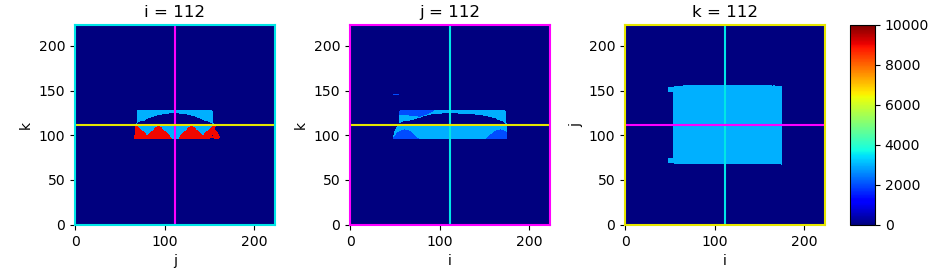

In [114]:
%matplotlib widget
import project.visual.matplotlib

image = project.core.fileio.load_nibabel(ex.paths['input_image']).get_fdata()
density = project.core.fileio.load_nibabel(ex.paths['density_field']).get_fdata()
elastic = project.core.fileio.load_nibabel(ex.paths['elastic_field']).get_fdata()

clim = (float(image.min()), float(image.max()))
print(clim)

_ = project.visual.matplotlib.show_image_slices(image, cmap='gray', clim=(0, 1), colors='cmy')
_ = project.visual.matplotlib.show_image_slices(density, cmap='gray', clim=(0, 1000), colors='cmy')
_ = project.visual.matplotlib.show_image_slices(elastic, cmap='jet',  clim=(0, 10000), colors='cmy')
_ = project.visual.matplotlib.show_image_slices(material, cmap='jet',  clim=(0, 10), colors='cmy')

In [86]:
project.preprocessing.stages.interpolate_image_fields(
    image_path=ex.paths['input_image'],
    mesh_path=ex.paths['material_mesh'],
    output_path=ex.paths['interp_mesh'],
    config=config['preprocessing']['image_interpolation']
)

Loading ../../data/ShapeNetSem/TEST/e91c2df09de0d4b1ed4d676215f46734/images/pad37_regions_material_solid.nii.gz


FileNotFoundError: No such file or no access: '../../data/ShapeNetSem/TEST/e91c2df09de0d4b1ed4d676215f46734/images/pad37_regions_material_solid.nii.gz'